# Module: latticevectors

This module contains functions related to determining the lattice vectors, and making use of them in subsequent calculations.  This includes obtaining an initial guess at the lattice vectors, calculating refined fits to the lattice vectors at each diffraction pattern, strain mapping, and orientation mapping.

## Submodule: getlatticevectors_fromRadontransform

This notebook demoes obtaining an initial guess at the lattice vectors using the Radon transform of the average deconvolution, as follows:

* Mask the center of the deconvolution, if necessary
* Take the radon transform of the deconvolution
* At each angle, get a score indicating how likely this angle is a lattice direction
* Find two, non-colinear angles maximizing the score
* From these angles and the radon projections, get the corresponding vector lengths

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from skimage.transform import radon

from py4DSTEM.file.datastructure import PointList
from py4DSTEM.file.readwrite import FileBrowser, read, append

from py4DSTEM.process.latticevectors import get_radon_scores, get_lattice_directions_from_scores, get_lattice_vector_lengths

In [2]:
# Examine file contents

fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
browser = FileBrowser(fp)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    datacube                            DataCube            
   1    deconvolution                       DiffractionSlice    
   2    deconvolution_1                     DiffractionSlice    
   3    deconvolution_shiftcorrected        DiffractionSlice    
   4    deconvolution_shiftcorrected_ellipsecorrectedDiffractionSlice    
   5    deconvolution_uncorrected           DiffractionSlice    
   6    diffractionslice_3                  DiffractionSlice    
   7    probe_kernel                        DiffractionSlice    
   8    DF_image                            RealSlice           
   9    DF_image_1                          RealSlice           
   10   diffraction_shifts                  RealSlice           
   11   diffraction_shifts_1                RealSlice           
   12   diffraction_shifts_2                RealSlice           
   13   realslice_0                         RealSlice           
   14   strain_m

In [3]:
# Load data

dc = browser.get_dataobject('datacube')
braggpeaks = browser.get_dataobject('Braggpeaks_shifted_ellipsecorrected')
deconvolution = browser.get_dataobject('deconvolution_shiftcorrected_ellipsecorrected').data2D
browser.close()

### Get mask for unscattered beam

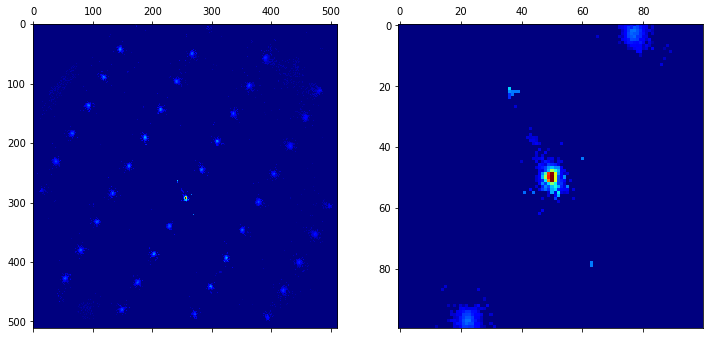

In [4]:
# Show deconvolution

power=0.25

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(deconvolution,sigma=2)),(dc.Q_Nx,dc.Q_Ny))

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
ax1.matshow(deconvolution**power,cmap='jet')
ax2.matshow(deconvolution[x0-50:x0+50,y0-50:y0+50]**power,cmap='jet')
plt.show()

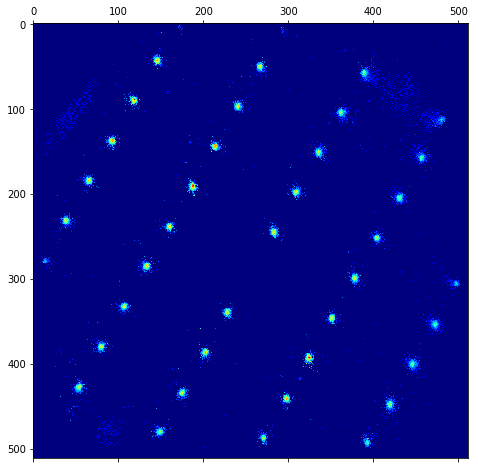

In [5]:
# Get mask for unscattered beam

maskrad = 40
power=0.25

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(deconvolution,sigma=2)),(dc.Q_Nx,dc.Q_Ny))
ry,rx = np.meshgrid(np.arange(dc.Q_Ny),np.arange(dc.Q_Nx))
mask = ((rx-x0)**2+(ry-y0)**2) > maskrad**2

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow((deconvolution*mask)**power,cmap='jet')
plt.show()

### Take radon transform and get scores

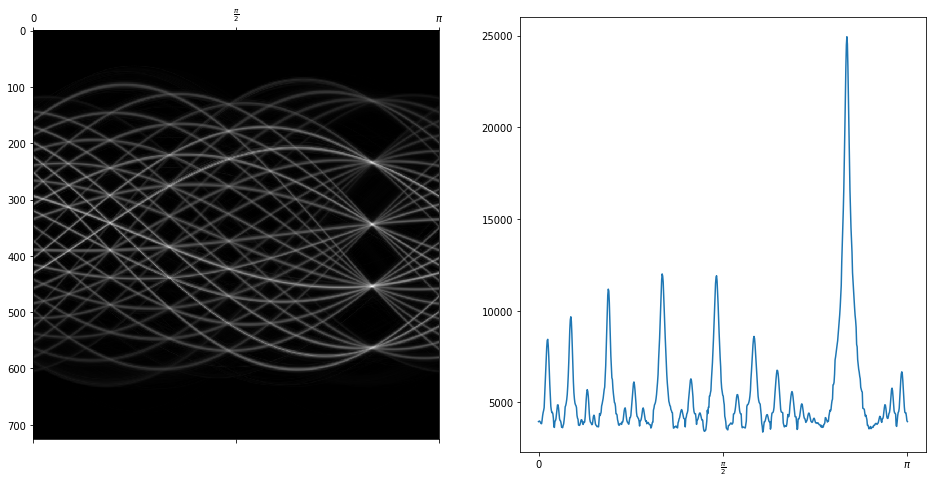

In [6]:
# Get scores

N_angles = 720
sigma = 2
minSpacing = 10
minRelativeIntensity = 0.05

power = 0.5

scores, thetas, sinogram = get_radon_scores(deconvolution, mask, N_angles, sigma, minSpacing, minRelativeIntensity)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.matshow(sinogram**power)
ax1.set_xticks([0,sinogram.shape[1]/2,sinogram.shape[1]])
ax1.set_xticklabels(['0',r'$\frac{\pi}{2}$',r'$\pi$'])
ax2.plot(thetas,scores)
ax2.set_xticks([0,np.pi/2.,np.pi])
ax2.set_xticklabels(['0',r'$\frac{\pi}{2}$',r'$\pi$'])
plt.show()

### Get lattice directions

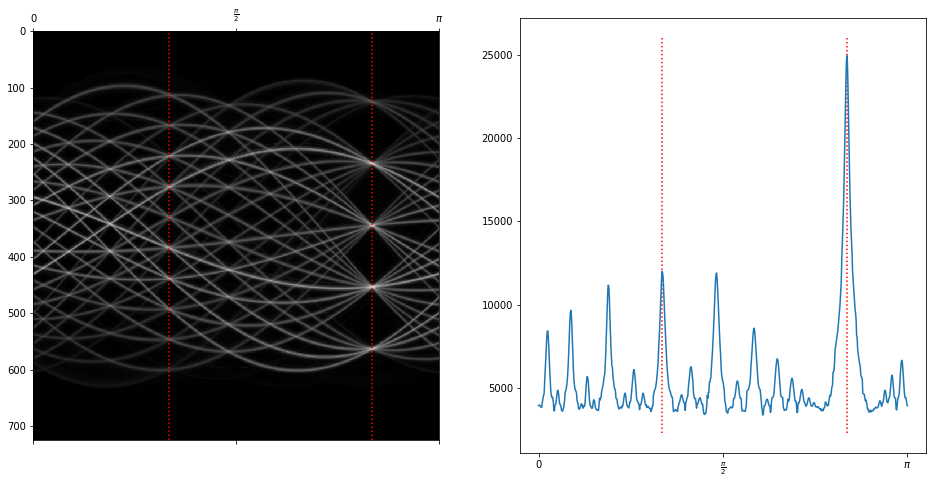

Initial guess at u and v angles is 150.5 and 60.33, respectively.


In [7]:
# Get lattice directions

sigma = 2
minSpacing = 10
minRelativeIntensity = 0.05
index1 = 0
index2 = 0

power = 0.5

u_theta, v_theta = get_lattice_directions_from_scores(thetas, scores, sigma, minSpacing, minRelativeIntensity,
                                                                                         index1, index2)

u_theta_ind = np.argmin(np.abs(thetas-u_theta))
v_theta_ind = np.argmin(np.abs(thetas-v_theta))
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.matshow(sinogram**power)
ax1.set_xticks([0,sinogram.shape[1]/2,sinogram.shape[1]])
ax1.vlines((u_theta_ind,v_theta_ind),ax1.get_ylim()[0],ax1.get_ylim()[1],linestyle=":",color='r')
ax1.set_xticklabels(['0',r'$\frac{\pi}{2}$',r'$\pi$'])
ax2.plot(thetas,scores)
ax2.vlines((u_theta,v_theta),ax2.get_ylim()[0],ax2.get_ylim()[1],linestyle=":",color='r')
ax2.set_xticks([0,np.pi/2.,np.pi])
ax2.set_xticklabels(['0',r'$\frac{\pi}{2}$',r'$\pi$'])
plt.show()

print("Initial guess at u and v angles is {:.4} and {:.4}, respectively.".format(np.degrees(u_theta),np.degrees(v_theta)))

### Get lattice vector lengths

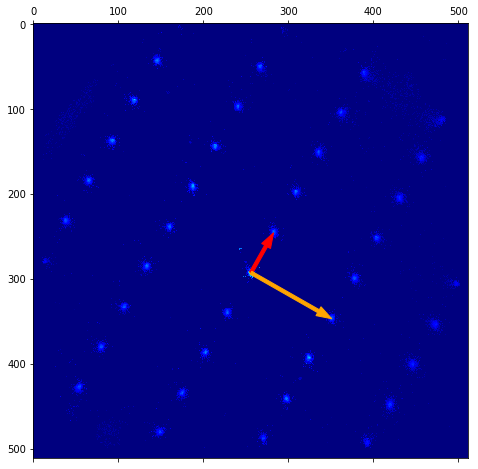

In [9]:
spacing_thresh = 1.5
sigma = 2
minSpacing = 2
minRelativeIntensity = 0.1

power = 0.25

u_length, v_length = get_lattice_vector_lengths(u_theta, v_theta, thetas, sinogram,
                                                spacing_thresh, sigma, minSpacing, minRelativeIntensity)

# Show
x0,y0 = np.unravel_index(np.argmax(gaussian_filter(deconvolution,sigma=2)),(dc.Q_Nx,dc.Q_Ny))
u_dx = np.cos(u_theta)*u_length
u_dy = np.sin(u_theta)*u_length
v_dx = np.cos(v_theta)*v_length
v_dy = np.sin(v_theta)*v_length

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(deconvolution**power,cmap='jet')
ax.arrow(y0,x0,u_dy,u_dx, color='red',width=4,length_includes_head=True)
ax.arrow(y0,x0,v_dy,v_dx, color='orange',width=4,length_includes_head=True)
plt.show()